In [1]:
# Проверка среды выполнения СoLab/Local
oncolab = 'google.colab' in str(get_ipython())
if oncolab:
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [2]:
!pip install uproot3 awkward particle scikit-learn 'iminuit<2' probfit cupy-cuda110
!pip install gputil psutil humanize

In [3]:
# memory footprint support libraries/code
import os, psutil, humanize
import GPUtil as GPU
def printrss():
  process = psutil.Process(os.getpid())
  !cat /proc/cpuinfo | fgrep "model name" | sed -r "s/^model name\s+:\s+(.+)/\1/"
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  !df
  try:
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    print("GPU", gpu.name, "| driver", gpu.driver)
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  except:
    print("No GPU provided")
    gpu = None
  return gpu

gpu = printrss()

Intel(R) Xeon(R) CPU @ 2.20GHz
Intel(R) Xeon(R) CPU @ 2.20GHz
Gen RAM Free: 12.6 GB  | Proc size: 118.2 MB
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay         71724152 52689340  19018428  74% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6666780        0   6666780   0% /sys/fs/cgroup
shm              6029312        0   6029312   0% /dev/shm
tmpfs            6666780       88   6666692   1% /var/colab
/dev/sda1       78224816 60060572  18147860  77% /opt/bin
tmpfs            6666780        0   6666780   0% /proc/acpi
tmpfs            6666780        0   6666780   0% /proc/scsi
tmpfs            6666780        0   6666780   0% /sys/firmware
drive           71724152 53656648  18067504  75% /mntDrive
GPU Tesla T4 | driver 460.32.03
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [4]:
#@title Настройка выполнения кода
mode = "beta" #@param ["beta", "class"]

verbose = False #@param {type:"boolean"}

updateEDF = False #@param {type:"boolean"}

updateNNdata = False #@param {type:"boolean"}

useCuPy = True #@param {type:"boolean"}

# отключение использования CuPy, если GPU не выделен
if gpu is None:
  useCuPy = False

# Варианты частоты темновых шумов на 1 кв. мм.
dcr_vars = (0, 1000, 2000, 5000, 10000, 20000, 50000, 1e5, 5e5, 1e6) #@param {type:"raw"}

In [5]:
#@title Настройка модели нейросети
nPhiBins =  10#@param {type:"integer"}

restoreModel = True #@param {type:"boolean"}

updateModelFit = False #@param {type:"boolean"}

maxepochs = 300 #@param {type:"integer"}

batchSize = 1024 #@param {type:"integer"}

# конфигурация скрытых слоев нейросети
hlayers = (200, 100, 50, 20)


In [6]:
import glob
if oncolab:
  from google.colab import drive 
  drive.mount('/mntDrive')  # смонтировать диск в папке «mntDrive»   
  datadir = '/mntDrive/My Drive/FARICH/Reconstruction/NN/data'
else:
  datadirs = [r'C:\Users\skono\Google Диск (skononov@nsu.ru)\FARICH\Reconstruction\NN\data', \
              r'D:\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data', \
              r'C:\Users\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data']
  datadir = None
  for dir in datadirs:
    if os.access(dir, os.R_OK):
      datadir = dir
      os.chdir(datadir)
      break

betatrain_filenames = [os.path.join(datadir, 'pi-pi-', 'rndm', fn) for fn in ['farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root','farichsim_pi-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root']]
class_filenames = [os.path.join(datadir, 'mu-pi-', 'rndm', 'farichsim_mu-pi-_45-360deg_120.0k_ideal_2020-12-07_rndm.root'),]

rootFilenameMap = {'beta': betatrain_filenames, 'class': class_filenames}

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


In [7]:
import sys
srcdir = os.path.dirname(datadir)
if srcdir not in sys.path:
  sys.path.append(srcdir)
from farichnnlib import *

In [8]:
strategy = initcompstrategy(oncolab)

Could not set TPU distribution strategy!
Please provide a TPU Name to connect to.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Physical devices cannot be modified after being initialized
2 physical devices: /physical_device:CPU:0 /physical_device:GPU:0
1 physical GPUs: /physical_device:GPU:0
0 physical TPUs: 
2 logical devices: /device:CPU:0 /device:GPU:0
1 logical GPUs: /device:GPU:0
0 logical TPUs: 


In [9]:
# Копирование данных на локальный диск
if oncolab:
  someresmissing = any([not os.access(datadir + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_nndata.h5', os.R_OK) for dcr in dcr_vars])
  if someresmissing or updateNNdata:
    for fn in rootFilenameMap[mode]:
      !cp -uv "$fn" .
    rootFilenameMap[mode] = ['./'+os.path.basename(fn) for fn in rootFilenameMap[mode]]

In [10]:
# Обработка данных из ROOT-файлов без промежуточного сохранения в edf
hdfilename = None
for dcr in dcr_vars: 
  nndatafilename = datadir + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_nndata.h5'
  if not os.access(nndatafilename, os.R_OK) or updateNNdata:
    print(f'Generating NN data with DCR/mm^2 {dcr:.0f}...')
    processdata(rootFilenameMap[mode], hdfilename, nndatafilename, mode, nbins=nPhiBins, \
                noisefreqpersqmm=dcr, updateEDF=updateEDF, verbose=verbose, usecupy=useCuPy, recorigtime=True)

Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_phibins10_noise0_gate1ns_tcor_model...
No existing model is found
Build TF model with hidden layer configuration (200, 100, 50, 20) and input shape (51,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               10400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 

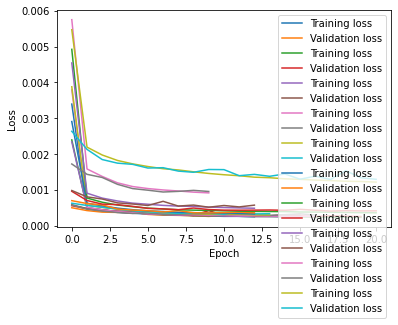

In [11]:
# Вызовы построения и тренировки нейросети

import shutil

n_max, nhyp = get_sim_pars(nndatafilename)

for dcr in dcr_vars:
  nndatafilename = datadir + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_nndata.h5'
  datadir_Model = datadir + os.sep + 'Model'
  model_path = datadir_Model + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_model'

  nndata_dtypes, nndata_shapes = get_nndata_format(nndatafilename)

  model = None
  if restoreModel:
    try:
      print(f'Restoring model from path {model_path}...')
      with strategy.scope():
        model = tf.keras.models.load_model(model_path)
      assert(model.inputs[0].shape[1] == nndata_shapes[0][0])
      model.summary()
    except:
      print('No existing model is found') 

  if model is None or updateModelFit:
    if model is None:
      model = build_model(nndata_shapes[0], mode, hlayers, nhyp=nhyp)
      model.summary()

    stopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, restore_best_weights=True)

    print(f'Reading data&labels from {nndatafilename}...')
    test_data = pd.read_hdf(nndatafilename, 'test_data')
    test_labels = pd.read_hdf(nndatafilename, 'test_labels')
    train_data = pd.read_hdf(nndatafilename, 'train_data').to_numpy()
    train_labels = pd.read_hdf(nndatafilename, 'train_labels').to_numpy()

    bufferSize = train_data.shape[0]
    trainStepsPerEpoch = train_data.shape[0]//batchSize
    testStepsPerEpoch = test_data.shape[0]//batchSize

    if mode=='beta':
      train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
      test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels, test_labels)).repeat().batch(batchSize, True)
    else:
      train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(bufferSize).repeat().batch(batchSize, True)
      test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).repeat().batch(batchSize, True)

    del train_data, train_labels

    #print(f'Train data size: {train_rows} events, validate/test data size: {test_rows} events')

    print(f'Fitting model for at maximum {maxepochs} epochs...')
    history = model.fit(train_dataset, epochs=maxepochs,
                        validation_data=test_dataset,
                        callbacks=[stopCallback],
                        steps_per_epoch=trainStepsPerEpoch,
                        validation_steps=testStepsPerEpoch)

    last_epoch = len(history.history['loss'])
    print("Last epoch number:", last_epoch)
    model.save(model_path)

    plt.plot(history.history['loss'], '-', label='Training loss')
    plt.plot(history.history['val_loss'], '-', label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
  

In [12]:
'''
def evalSigmaBeta(nndatafilename, model_path, nbetapnts=10, theta_min=0, theta_max=10):
  print(f'Reading test data from {nndatafilename}...')
  test_data = pd.read_hdf(nndatafilename, 'test_data')
  test_labels = pd.read_hdf(nndatafilename, 'test_labels')
  print(f'"test_data" data frame read with {test_data.shape[0]} entries')  

  with strategy.scope():
    print(f'Restoring model from path {model_path}...')
    model = tf.keras.models.load_model(model_path)
    print(f'Predicting beta values...')
    prediction = model.predict(test_data).flatten()

  # Break up data into bins on beta and theta
  betas = 1/n_max + (1-1/n_max) * test_labels
  beta_residual = (1-1/n_max) * (prediction-test_labels)
  thetas = test_data['theta_p_norm']*90 # градусы
  beta_min, beta_max = betas.min(), betas.max()+1e-5
  theta_mask = (thetas>=theta_min) & (thetas<theta_max)
  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]
  beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (betas-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
  resdfgrp = pd.DataFrame({'beta_pnt': beta_pnt, 'residual': beta_residual}, dtype=np.float64).groupby('beta_pnt')

  accdf = resdfgrp.apply(gausSigmaWithError, iname='residual', onames=('sigma', 'sigma_error'))

  beta_set = accdf.index.to_numpy()
  sigbeta = accdf['sigma'].to_numpy()
  sigbeta_error = accdf['sigma_error'].to_numpy()  
  return beta_set, sigbeta, sigbeta_error
'''

'\ndef evalSigmaBeta(nndatafilename, model_path, nbetapnts=10, theta_min=0, theta_max=10):\n  print(f\'Reading test data from {nndatafilename}...\')\n  test_data = pd.read_hdf(nndatafilename, \'test_data\')\n  test_labels = pd.read_hdf(nndatafilename, \'test_labels\')\n  print(f\'"test_data" data frame read with {test_data.shape[0]} entries\')  \n\n  with strategy.scope():\n    print(f\'Restoring model from path {model_path}...\')\n    model = tf.keras.models.load_model(model_path)\n    print(f\'Predicting beta values...\')\n    prediction = model.predict(test_data).flatten()\n\n  # Break up data into bins on beta and theta\n  betas = 1/n_max + (1-1/n_max) * test_labels\n  beta_residual = (1-1/n_max) * (prediction-test_labels)\n  thetas = test_data[\'theta_p_norm\']*90 # градусы\n  beta_min, beta_max = betas.min(), betas.max()+1e-5\n  theta_mask = (thetas>=theta_min) & (thetas<theta_max)\n  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]\n  beta_pnt = beta_min + (be

In [13]:
def shape(x, N, mean, sigma, c):
  '''
  Gaussian with constant background
  '''
  return N * gaussian(x, mean, sigma) + c

def feature_to_beta(feature):
  beta_min = 1/n_max
  return beta_min + (1-beta_min) * feature

def evalSigmaBeta(nndatafilename, model_path, transfunc, nbetapnts=10, theta_min=0, theta_max=10, draw=False):
  print(f'Reading test data from {nndatafilename}...')
  test_data = pd.read_hdf(nndatafilename, 'test_data')
  test_labels = pd.read_hdf(nndatafilename, 'test_labels')

  with strategy.scope():
    print(f'Restoring model from path {model_path}...')
    model = tf.keras.models.load_model(model_path)
    print(f'Predicting beta values...')
    prediction = model.predict(test_data).flatten()

  # Break up data into bins on beta and theta
  if 'rawbeta' in nndatafilename:
    betas = test_labels
  else:
    betas = transfunc(test_labels)
  beta_residual = transfunc(prediction) - betas
  thetas = test_data['theta_p_norm']*90 # градусы
  beta_min, beta_max = betas.min(), betas.max()+1e-5
  theta_mask = (thetas>=theta_min) & (thetas<theta_max)
  betas, beta_residual = betas[theta_mask], beta_residual[theta_mask]
  beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (betas-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
  resdfgrp = pd.DataFrame({'beta_pnt': beta_pnt, 'residual': beta_residual}, dtype=np.float64).groupby('beta_pnt')

  beta_set = np.zeros(nbetapnts)
  sigbeta = np.zeros(nbetapnts)
  sigbeta_error = np.zeros(nbetapnts)

  if draw:
    plt.figure(figsize=(12,nbetapnts*3))
  isp = 0
  for b, data in resdfgrp:
    series = data['residual']
    mean, sd = series.mean(), series.std()
    q1, q2 = mean-3*sd, mean+3*sd
    cutseries = series[(q1<series)&(series<q2)]

    #blh = BinnedLH(shape, cutseries, bins=100, bound=(q1,q2))
    blh = BinnedLH(gaussian, cutseries, bins=100, bound=(q1,q2))
    m = Minuit(blh, mean=cutseries.mean(), sigma=cutseries.std(), print_level=0)
    m.errordef = Minuit.LIKELIHOOD

    r = m.migrad() # fit

    #print(r)

    beta_set[isp] = b
    sigbeta[isp] = m.values['sigma']
    sigbeta_error[isp] = m.errors['sigma']

    if draw:
      plt.subplot((nbetapnts+1)//2, 2, isp+1)
      blh.draw(m)
      plt.semilogy()
      plt.title(fr'$\beta$={beta_set[isp]:6.4f}')
      plt.tight_layout()
    isp += 1

  return beta_set, sigbeta, sigbeta_error

In [14]:
nbetapnts = 10
suffixes = [f'_noise{dcr:.0f}' for dcr in dcr_vars]
labels = [f'DCR = {dcr/1e3:.0f} kcps' for dcr in dcr_vars]
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

fig = plt.figure(figsize=(10,10))
for i, dcr in enumerate(dcr_vars):
  nndatafilename = datadir + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_nndata.h5'
  model_path = datadir_Model + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}_gate1ns_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)

  plt.figure(fig.number)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])

plt.figure(fig.number)
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta<10^0$', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_gate1ns_tcor_vardcr.png')

Output hidden; open in https://colab.research.google.com to view.

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_phibins10_noise1000000_gate1ns_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_phibins10_noise1000000_gate1ns_tcor_model...
Predicting beta values...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is re

Reading test data from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/beta_phibins10_noise1000000_tcor_nndata.h5...
Restoring model from path /mntDrive/My Drive/FARICH/Reconstruction/NN/data/Model/beta_phibins10_noise1000000_tcor_model...
Predicting beta values...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is really small return 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: LogWarning: x is re

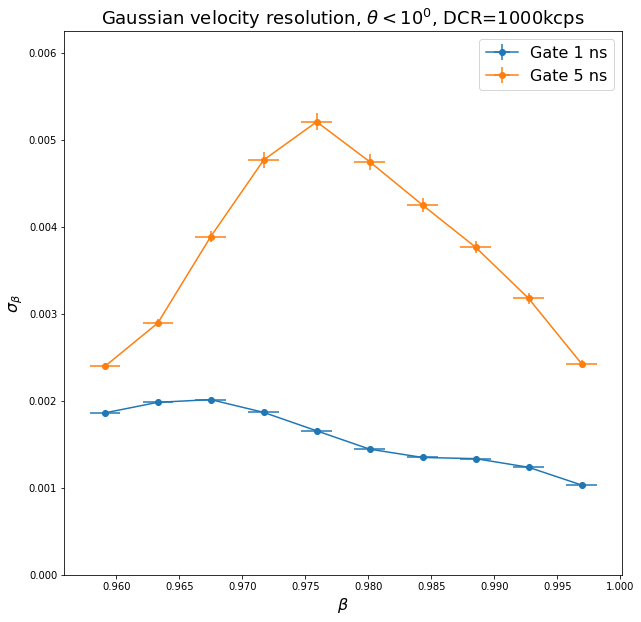

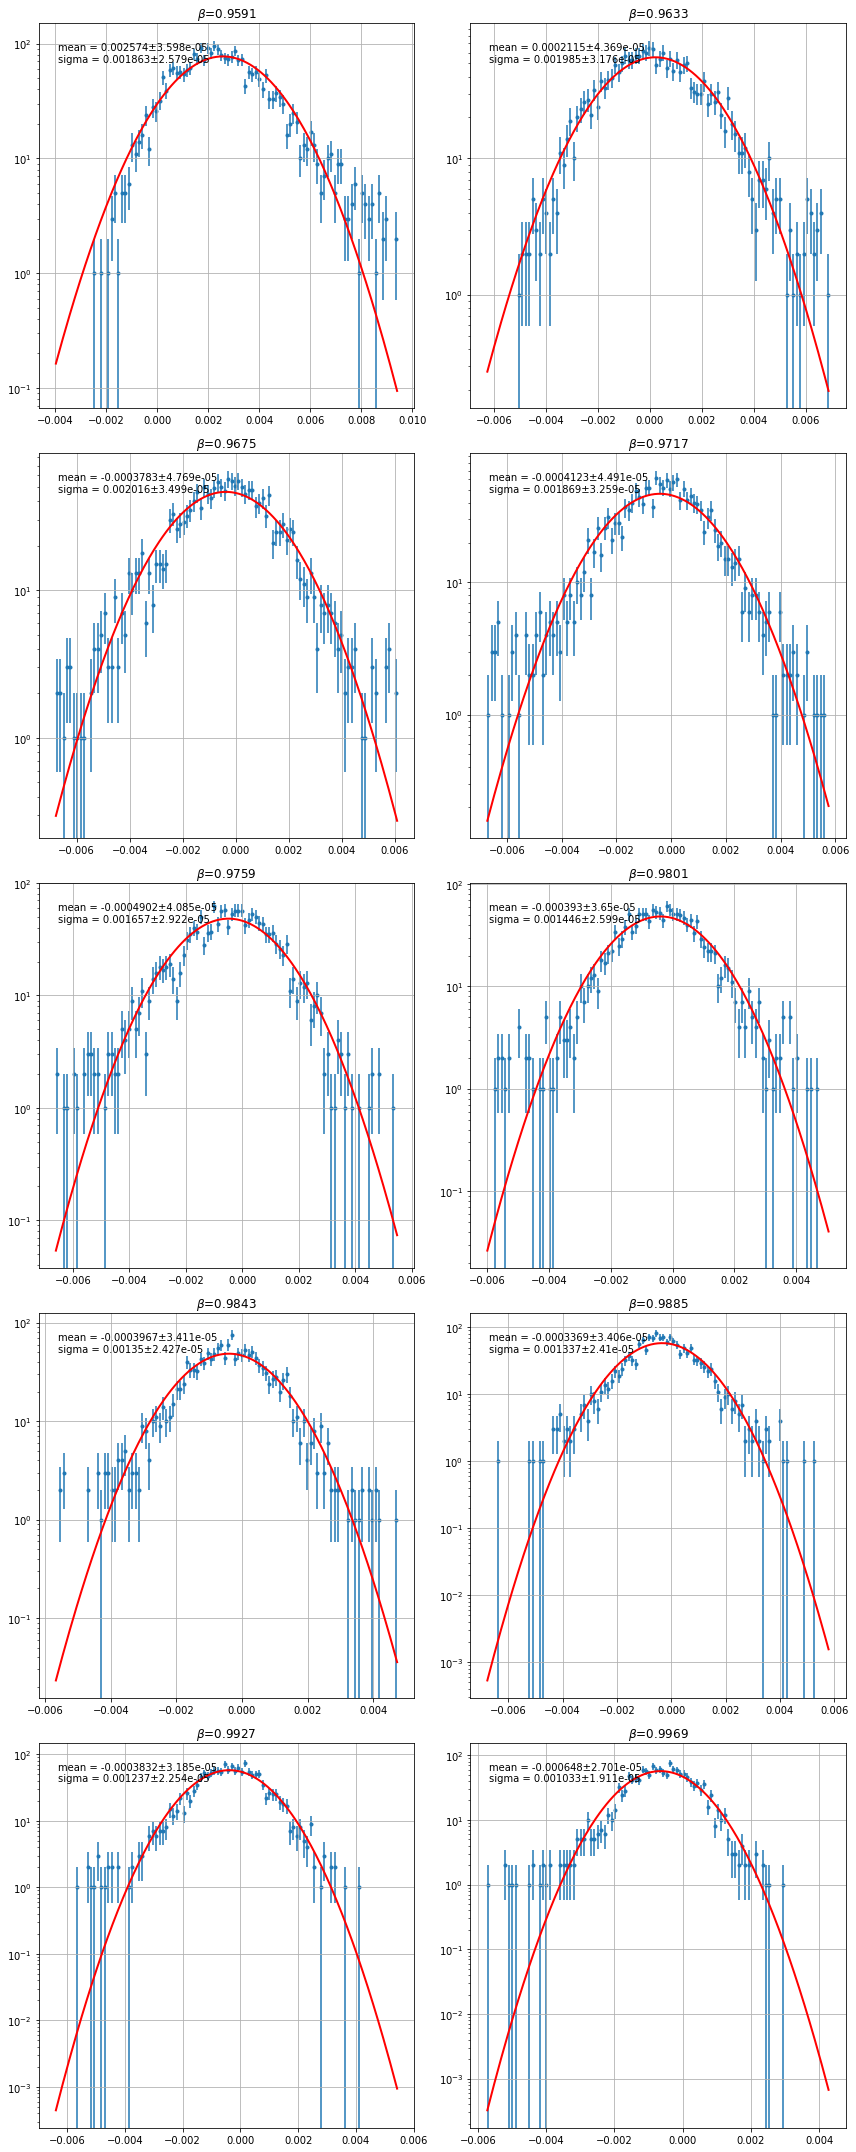

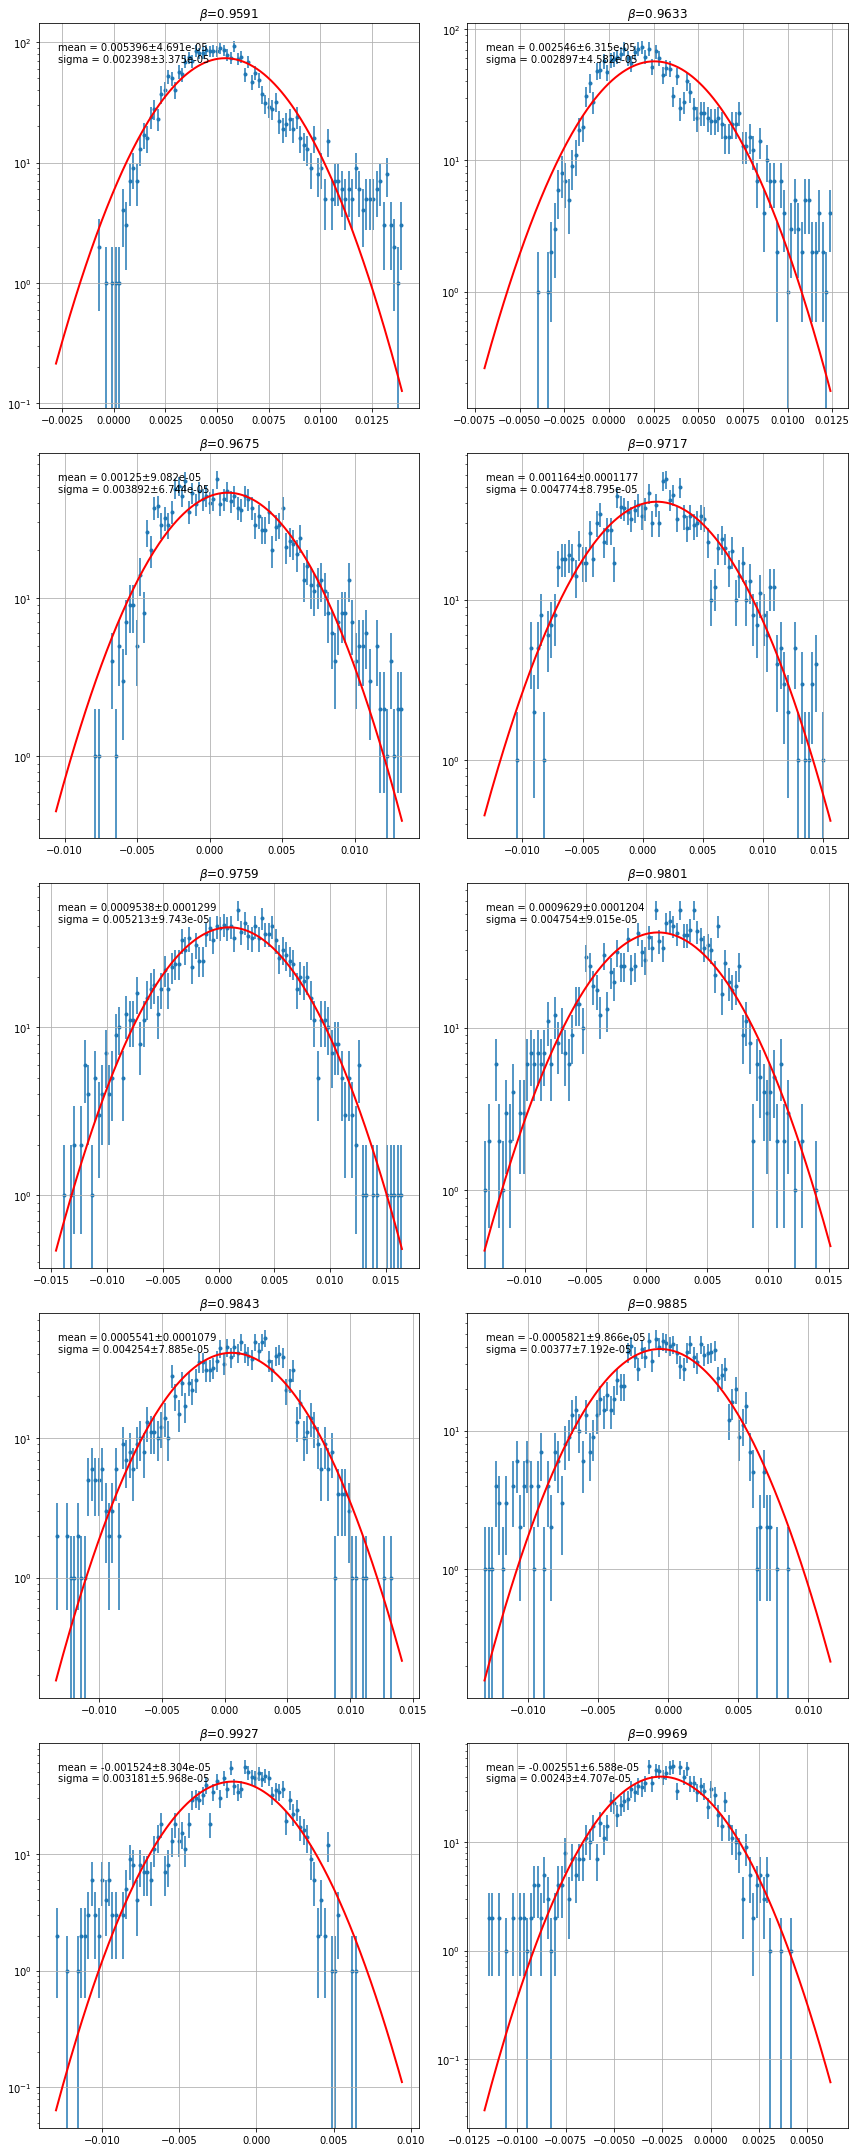

In [17]:
nbetapnts = 10
dcr = 1000000
suffixes = ['_gate1ns', '']
labels = ['Gate 1 ns', 'Gate 5 ns']
nplots = len(suffixes)
betas = np.zeros((nbetapnts, nplots))
sigbetas = np.zeros((nbetapnts, nplots))
sigbeta_errors = np.zeros((nbetapnts, nplots))

fig = plt.figure(figsize=(10,10))
for i in range(nplots):
  nndatafilename = datadir + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}' + suffixes[i] + '_tcor_nndata.h5'
  model_path = datadir_Model + os.sep + f'{mode}_phibins{nPhiBins}_noise{dcr:.0f}' + suffixes[i] + '_tcor_model'
  betas[:,i], sigbetas[:,i], sigbeta_errors[:,i] = evalSigmaBeta(nndatafilename, model_path, feature_to_beta, nbetapnts, theta_min=0, theta_max=10, draw=True)
  dbeta = (betas[1,i] - betas[0,i]) / np.sqrt(12)

  plt.figure(fig.number)
  plt.errorbar(betas[:,i], sigbetas[:,i], xerr=dbeta, yerr=sigbeta_errors[:,i], fmt='-o', label=labels[i])

plt.figure(fig.number)
plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel(r'$\sigma_\beta$', fontsize=16)
plt.title(rf'Gaussian velocity resolution, $\theta<10^0$, DCR={dcr/1e3:.0f}kcps', fontsize=18)
plt.ylim(0, 1.2*sigbetas.max())
plt.legend(fontsize=16)
plt.savefig(datadir + os.sep + f'beta_gaus_res_theta0-10deg_dcr{dcr/1e3:.0f}kcps_tcor_timegates.png')